In [1]:
import numpy as np
import pandas as pd
import math
#from tletools import TLE
import time
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import csv
from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite
from skyfield.elementslib import OsculatingElements
from skyfield.data import spice
import matplotlib.dates as mdates

### No need to run

In [13]:
constellation = "starlink"
path = "../../tle/"
max_isl = 4782.174752610824

In [4]:
cbf_file = path + constellation + "_u_pos_cbf_3_month.npy"
pos_file = path + constellation + "_u_pos_3_month.npy"
ext_file = path + constellation + "_u_extend_m_3_month.npy"
vel_file = path + constellation + "_u_velocity_3_month.npy"

pos_cbf=np.load(cbf_file,allow_pickle=True).tolist()
print(type(pos_cbf[0][0][0]))
print(pos_cbf[0][0])
print(np.shape(pos_cbf))

pos=np.load(pos_file,allow_pickle=True).tolist()
print(type(pos[0][0][0]))
print(pos[0][0])
print(np.shape(pos))

extend_m = np.load(ext_file,allow_pickle=True).tolist()
print(type(extend_m[0][0][0]))
print(extend_m[0][0])
print(np.shape(extend_m))

velocity = np.load(vel_file,allow_pickle=True).tolist()
print(type(velocity[0][0][0]))
print(velocity[0][0])
print(np.shape(velocity))

<class 'float'>
[-6053.995926609168, -874.6018578643767, 3238.421525132463]
(1686, 15840, 3)
<class 'float'>
[27.923081914311325, -0.8406291481134366, 547.7352901960046]
(1686, 15840, 3)
<class 'float'>
[84.86641998843886, 311.07243633325197, 164.79065562627238, 6927.731917274687]
(1686, 144, 4)
<class 'float'>
[3.3243790438689476, -4.732348547617833, 4.919057534542607]
(1686, 15840, 3)


In [5]:
# 筛选过滤后卫星对应的位置信息
def read_txt(file):
    r = []
    with open(file,"r") as f:
        line = f.readline()
        while line:
            r.append(int(line.strip('\n')))
            line = f.readline()
    return r
f_keys = read_txt("../../tle/data/filtered_index.txt")
print(len(f_keys))

def filter_pos():
    r, rr, ee, v = [], [], [], []
    for item in f_keys:
        r.append(pos_cbf[item])
        rr.append(pos[item])
        ee.append(extend_m[item])
        v.append(velocity[item])
    return r, rr, ee, v
pos_cbf, pos, extend_m, velocity = filter_pos()
print(np.shape(pos_cbf), np.shape(pos), np.shape(extend_m), np.shape(velocity))

node_num = len(pos)
cycle = len(pos[0])

1541
(1541, 15840, 3) (1541, 15840, 3) (1541, 144, 4) (1541, 15840, 3)


In [30]:
file = "../../tle/data/filtered_3_month.csv"
# file = "./data/sat_3_month.csv"
df = pd.read_csv(file,header=None,sep='\t')
data = df[0].str.split(',').values.tolist()
print(np.shape(data), data[0])
node_num = len(data)

(1541, 2) ['44713', '19074A']


In [15]:
tle_file = path + "tle_starlink_3_month_0401_0712.npy"
tle_data = np.load(tle_file, allow_pickle=True)
print("type: ", type(tle_data.item()))
tle_item = tle_data.item()
print("type: ", type(tle_item))
tle = tle_item.items()
d = {}
for k,v in tle:
    d[k] = v # v是多维的，两个月左右的数据，采样粒度可能有区别
print("Total: ",len(d), d['47150'][0])

# keys = [item[0] for item in data]
# print("Number of satellite: ", len(keys))

type:  <class 'dict'>
type:  <class 'dict'>
Total:  1701 ['2022-04-01 05:20:18', '1 47150U 20088AE  22091.22243163  .00004265  00000-0  30493-3 0  9991', '2 47150  53.0541 269.1438 0001347  72.7409 287.3727 15.06410475 75421', '6925.316']


In [16]:
np.save('./data/d.npy',d)

In [32]:
np.save('./data/keys.npy',keys)

In [8]:
# 获取卫星名称
file = "../../tle/data/norad_cat_id.csv"
df = pd.read_csv(file,header=None,sep='\t')
df.drop(labels=None,axis=0, index=0, columns=None, inplace=True)
satname = df[0].str.split(',').values.tolist()
print(len(satname), satname[0][1].strip('\"'))
names = {}
for sat in satname:
    names[sat[1].strip('\"')] = sat[3].strip('\"')

53351 1


In [10]:
# liuwei的数据
pos_file = path + "position_height_lat_long_41_719_decay_1409.npy"
posdata = np.load(pos_file,allow_pickle=True)
posdata = posdata.item()
print(type(posdata), len(posdata))

f_keys = np.load("./data/sat_1541.npy", allow_pickle=True).tolist()
print(len(f_keys), f_keys[0])

def transdata():
    r, cbf = [], []
    c = 0
    for key in f_keys:
        key = int(key)
        if key in posdata:
            c += 1
            r.append(posdata[key]['lat_long'])
            cbf.append(posdata[key]['position'])
        else:
            r.append([])
            cbf.append([])
    print(c)
    return r, cbf
pos, pos_cbf = transdata()
print(np.shape(pos), np.shape(pos_cbf))

<class 'dict'> 1409
1541 44713
1409
(1541,) (1541,)


### 卫星轨道信息

In [8]:
# 读入卫星所在轨道信息
file = "./data/sat_orbits_filtered_3_month.csv"
df = pd.read_csv(file,header=None,sep='\t')
df.drop(labels=None,axis=0, index=0, columns=None, inplace=True)
sat_data = df[0].str.split(',').values.tolist()
print(np.shape(sat_data), sat_data[0])

filtered_keys = []
for item in sat_data:
    filtered_keys.append(item[-1])
print(len(filtered_keys))

def establish_dict():
    d = {}
    for item in sat_data:
        d[item[-1]] = int(item[0])
    return d
name2orbit = establish_dict()
print(len(name2orbit))

# def read_sat_orbit():
#     d = {}
#     for i in range(len(sat_data)):
#         if int(sat_data[i][0]) not in d:
#             d[int(sat_data[i][0])] = [keys.index(sat_data[i][2])]
#         else:
#             d[int(sat_data[i][0])].append(keys.index(sat_data[i][2]))
#     return d
# sat_orbit = read_sat_orbit()
# print(len(sat_orbit), sat_orbit[1])

(1409, 3) ['1', '5', '45182']
1409
1409


In [9]:
np.save('./data/name2orbit.npy',name2orbit)

In [12]:
# 每个轨道内卫星根据经度排序
def sort_sat_lon(t):
    rr = []
    for o in sat_orbit:
        r = []
        for sat in sat_orbit[o]:
            lon = pos[sat][t][1]
            r.append([sat, lon])
        r = sorted(r, key = lambda x: x[1])
        r = [item[0] for item in r]
        rr.append(r)
    return rr
sorted_sat = sort_sat_lon(0)
print(np.shape(sorted_sat), sorted_sat[0])

(72,) [753, 161, 160, 167, 172, 164, 169, 747, 147, 163, 145, 184, 170, 171, 168, 166, 162, 785]


In [13]:
# 确定所有轨道0号卫星
sat_dir = np.load("../../tle/data/sat_dir_3_month.npy", allow_pickle=True).tolist()
print("sat direction shape: ", len(sat_dir))
def sat_0(t):
    max_isl = 4782.174752610824
    rr = []
    for o in range(len(sorted_sat)):
        r = []
        for sat in sorted_sat[o]:
            if sat_dir[sat] == 1:
                r.append([sat, abs(0 - pos[sat][t][0])])
        r = sorted(r, key = lambda x: x[1])
        sat0 = r[0][0]
        rr.append(sat0)
    return rr
sat0 = sat_0(0)
print("initial satellite: ", sat0, len(sat0))

def is_connected(t):
    flag = False
    for i in range(len(sat0)):
        x1, y1, z1 = pos_cbf[sat0[i]][t][0], pos_cbf[sat0[i]][t][1], pos_cbf[sat0[i]][t][2]
        x2, y2, z2 = pos_cbf[sat0[i-1]][t][0], pos_cbf[sat0[i-1]][t][1], pos_cbf[sat0[i-1]][t][2]
        dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
        dir1, dir2 = sat_dir[sat0[i]], sat_dir[sat0[i-1]]
        if dis < max_isl and dir1 == dir2:
            flag = True
        if not flag:
            return False
    return True
print(is_connected(0))    

sat direction shape:  1541
initial satellite:  [785, 792, 345, 852, 159, 899, 329, 745, 306, 871, 290, 1162, 273, 1195, 451, 1212, 249, 1404, 423, 1383, 412, 1341, 235, 1358, 598, 1126, 590, 580, 215, 1136, 562, 1281, 1295, 1311, 359, 908, 34, 913, 373, 1010, 940, 970, 365, 646, 134, 994, 638, 981, 1019, 1033, 499, 704, 100, 718, 497, 1086, 702, 1077, 459, 668, 75, 542, 675, 1265, 1248, 1240, 524, 1215, 179, 822, 535, 833] 72
True


In [14]:
# 再次排序,0号卫星在左侧
def sort_sat0():
    r = []
    for i in range(len(sorted_sat)):
        tmp = sorted_sat[i]
        ini = tmp.index(sat0[i])
        tmp1, tmp2 = tmp[:ini], tmp[ini:]
        tmp2.extend(tmp1)
        r.append(tmp2)
    return r
sorted_sat = sort_sat0()
print(len(sorted_sat), sorted_sat[20])
# [270, 1406, 267, 284, 265, 263, 259, 262, 260, 258, 274, 272, 275, 264, 273, 271, 268, 269, 261]
# [1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176]

72 [412, 413, 407, 406, 421, 417, 416, 404, 420, 405, 418, 403, 419, 408, 415, 914, 411, 414, 410, 409]


### 每个时刻最近邻居

In [ ]:
# 计算每个时刻每个卫星最近的邻居 1409 * cycle * 4 [2intra, 2inter] 不考虑是否能够建链
def cal_nearest_neighbor():
    r = {}
    cycle = len(pos[0])
    for t in range(cycle): # 每个时刻
        sorted_sat = sort_sat_lon(t) 
        for i in range(len(sorted_sat)): # 每个轨道
            sats = sorted_sat[i]
            for j in range(len(sats)):
                sat = sats[j]
                if sat not in r:
                    r[sat] = [] 
                # intra
                up_neigh = sats[(j+1) % len(sats)]
                down_neigh = sats[j-1]
                tmp = [up_neigh, down_neigh]
                # inter
                x1, y1, z1 = pos_cbf[sat][t][0], pos_cbf[sat][t][1], pos_cbf[sat][t][2]
                
                neighs = sorted_sat[i-1]
                minn, index = float('inf'), -1
                for neigh in neighs:
                    x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                    dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    if dis < minn:
                        minn, index = dis, neigh
                tmp.append(index)
                
                neighs = sorted_sat[(i+1) % len(sorted_sat)]
                minn, index = float('inf'), -1
                for neigh in neighs:
                    x2, y2, z2 = pos_cbf[neigh][t][0], pos_cbf[neigh][t][1], pos_cbf[neigh][t][2]
                    dis = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) ** 0.5
                    if dis < minn:
                        minn, index = dis, neigh
                tmp.append(index)
                r[sat].append(tmp)
        if t % 1000 == 0:
            print("done: ", t)
    return r
nearest = cal_nearest_neighbor()
print(len(nearest), np.shape(nearest[785]))
np.save("./data/nearest_lw_0719.npy", nearest)

In [16]:
# 统计邻居卫星改变时刻
def cal_neighbor_update_time():
    r = {}
    cycle = len(pos[0])
    for sat in nearest:
        r[sat] = []
        pre = set(nearest[sat][0])
        for t in range(1, cycle):
            now = set(nearest[sat][t])
            if pre != now:
                r[sat].append(t)
            pre = now
    return r

change_time = cal_neighbor_update_time()
print(len(change_time))

1409


In [21]:
np.save('change_time.npy',change_time)

### Start from this line

In [2]:
# 生成时间序列数组
def generate_time_series(start, end):
    current = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    end_item = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    time_delta = datetime.timedelta(seconds=3600) # modify
    time_series = [current]
    while current < end_item:
        next = current + time_delta
        time_series.append(next)
        current = next
    return time_series

In [3]:
filtered_keys = np.load('./data/filtered_keys.npy',allow_pickle=True).tolist()
name2orbit = np.load('./data/name2orbit.npy',allow_pickle=True).item()
d = np.load('./data/d.npy',allow_pickle=True).item()

In [4]:
def read_txt(file):
    r = []
    with open(file, "r") as f:  
        line = f.readline()
        while line:
            if line.strip('\n') in filtered_keys:
                r.append(line.strip('\n'))
            line = f.readline()
    return r
task_maneuver = read_txt("./data/task_maneuver.txt")
# task_maneuver = read_txt("./data/maneuver.txt")
# task_maneuver = read_txt("./data/unnecessary_case.txt")
print(task_maneuver, len(task_maneuver))
# 81-59=22 22个不在这个轨道面的卫星

['45568', '45579', '46168', '46326', '46334', '46364', '46671', '46712', '46756', '46757', '46770', '46789', '47138', '47139', '47153', '47372', '47384', '47393', '47394', '47399', '47645', '47646', '47666', '47722', '47729', '47732', '47735', '47738', '47768', '47805', '47827', '47836', '47901', '47911', '47913', '47995', '47998', '48018', '48022', '48092', '48093', '48112', '48125', '48128', '48135', '48292', '48364', '48368', '48395', '48458', '48459', '48462', '48481', '48484', '48578', '48640', '48648', '48666', '48684'] 59


In [5]:
f_keys = np.load("./data/sat_1541.npy", allow_pickle=True).tolist()

In [6]:
# 读入TLE数据
cbf_file = "./data/pos_cbf_3_month.npy"
pos_file = "./data/pos_3_month.npy"

tle_pos_cbf=np.load(cbf_file,allow_pickle=True).tolist()
# print(type(tle_pos_cbf[0][0][0]))
# print(tle_pos_cbf[0][0])
# print(np.shape(tle_pos_cbf))

tle_pos=np.load(pos_file,allow_pickle=True).tolist()
# print(type(tle_pos[0][0][0]))
# print(tle_pos[0][0])
# print(np.shape(tle_pos))

def filter_pos():
    r, rr = [], []
    for item in f_keys:
        r.append(tle_pos_cbf[item])
        rr.append(tle_pos[item])
    return r, rr
tle_pos_cbf, tle_pos = filter_pos()
print(np.shape(tle_pos_cbf), np.shape(tle_pos))

(1541,) (1541,)


In [7]:
keys = np.load('./data/keys.npy',allow_pickle=True).tolist()

/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


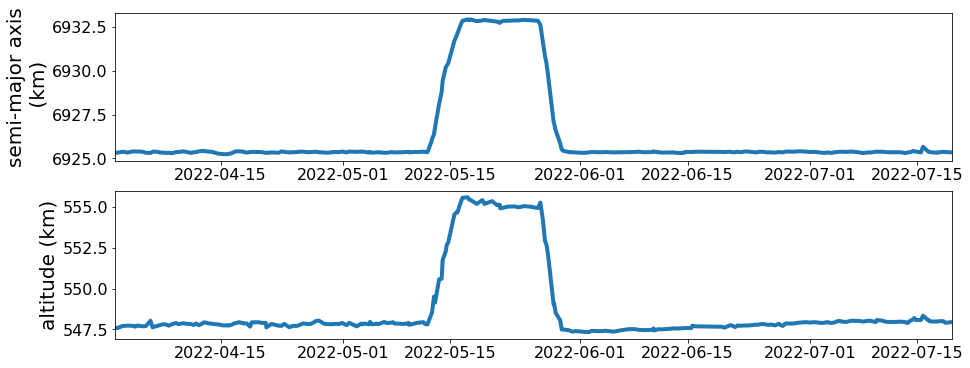

In [8]:
# 绘制半长轴和高度改变图
def plot_altitude_semi(mu):
    for sat in mu:
        index, orbit = keys.index(sat), name2orbit[sat] # index from 1
        altitude = [tle_pos[index][t][2] for t in range(len(tle_pos[index]))]
        semi = [round(float(item[-1]),2) for item in d[sat]]
        time_scale = [datetime.datetime.strptime(item[0], '%Y-%m-%d %H:%M:%S') for item in d[sat]]
        
        titles = ["semi-major axis (km)", "altitude (km)"]# , 'velocity'] #  'visible satellite'
        lines = ['-' if i%2==0 else '--' for i in range(4)]
        widths = [4 if i%2==0 else 2 for i in range(4)]
        fig = plt.figure(figsize=(15, int(len(titles)*2.5 + 1)))
        font3 = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 19,
        }
        ylabels = ["semi-major axis\n (km)", "altitude (km)"]
        
        for i in range(len(titles)):
            xpoints = time_scale
            if i == 0: # distance
                ypoints = semi
            elif i == 1: # delay
                ypoints = altitude
                
            plt.subplot(len(titles), 1, i+1)
            plt.subplots_adjust(wspace =0, hspace =0.2)#调整子图间距
            
            plt.plot(xpoints, ypoints, lines[0], linewidth = widths[0])
                    
            # plt.title(titles[i], font = font3, loc = 'center')
            plt.tick_params(labelsize=16)
            #plt.xlim(time_scale[0], time_scale[10])
            plt.xlim(time_scale[0], time_scale[-1])
            #plt.xlabel('time (10 minute)', font3)
#             if i == 0:
#                 plt.title("STARLINK-" + sat, font = font3, loc = 'center')
            
            plt.ylabel(ylabels[i], fontsize = 20)
            
            # plt.legend(loc=0)
        # plt.xlabel('time', font3)          
        #plt.savefig(sat + ".pdf",dpi=300,bbox_inches = 'tight')
        break

plot_altitude_semi(task_maneuver)